# 3 dimensional Continuous Wiener Process Acceleration Model


# All linear time invariant case. Continuous-discrete Kalman filter.

# Author: Ashiv Dhondea, RRSG, UCT.
# Created: 22 May 2016
# Validated: 24 May 2016

In [1]:
# Import the required libraries
import numpy as np
import math
from numpy import linalg
import scipy.linalg
from numpy.random import randn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define variables for the simulation
dt = 0.5 ; #[s]
t = np.arange(0,100,dt,dtype=float) # [s]

In [3]:
dimensionality = 3; # 3 dimensional problem
nStates = 3; # 3 states per dimension. position,velocity and acceleration
nVars = nStates*dimensionality; 
x_state = np.zeros([nVars,len(t)],dtype=float);

def fn_Generate_STM_polynom(zeta,nStates):
    # fn_Generate_STM_polynom creates the state transition matrix for polynomial models 
    # of degree (nStates-1) over a span of transition of zeta [s].
    # Polynomial models are a subset of the class of constant-coefficient linear DEs.
    # Refer to: Tracking Filter Engineering, Norman Morrison.
    stm = np.eye(nStates,dtype=float);
    for yindex in range (0,nStates):
        for xindex in range (yindex,nStates): # STM is upper triangular
            stm[yindex,xindex] = np.power(zeta,xindex-yindex)/float(math.factorial(xindex-yindex));
    return stm;     

def fn_Generate_STM_polynom_3D(zeta,nStates,dimensionality):
    # fn_Generate_STM_polynom_3D generates the full state transition matrix for 
    # the required dimensionality.
    stm = fn_Generate_STM_polynom(dt,nStates);
    stm3 = fn_Create_Concatenated_Block_Diag_Matrix(stm,dimensionality-1);
    return stm3;

def fn_Create_Concatenated_Block_Diag_Matrix(R,stacklen):
    # fn_Create_Concatenated_Block_Diag_Matrix creates a block diagonal matrix of size (stacklen) x (stacklen)
    # whose diagonal blocks are copies of the matrix R.
    L = [R]; 
    for index in range (0,stacklen):
        L.append(R);
        ryn = scipy.linalg.block_diag(*L);
    return ryn;

In [4]:
# Initialize  state vector
x_state[:,0] = np.array([0,0.01,0.5,
                         1,0.5,0.42,
                         1,0.02,0.36],dtype=float);
# Measurement matrix of the measurement model
H3 = np.eye(nVars,dtype=float);
# Measurement noise covariance matrix
R1 = np.diag([np.square(1.2),np.square(1.6),np.square(1.8)]); # for 1 dimension
R3 = fn_Create_Concatenated_Block_Diag_Matrix(R1,dimensionality-1); # for all 3 dimensions
y_meas = np.zeros([nVars,len(t)],dtype=float); # measurement vector.

# Find continuous-time process covariance matrix, then discretize it.
qtilde = np.sqrt(np.square(0.1*x_state[2,0])/dt); # Choice of process noise intensity.
# The theory behind Discretized Continuous-time kinematic models is discussed thoroughly
# in Bar-Shalom, Rong Li, Kirubarajan: Estimation with applications to tracking and navigation.
Qc00 = np.power(dt,5)/20; # See discussion in section 6.2.3
Qc01 = np.power(dt,4)/8;
Qc02 = np.power(dt,3)/6;
Qc21 = np.square(dt)/2
Qc = np.array([[Qc00,Qc01,Qc02],[Qc01,Qc02*2,Qc21],[Qc02,Qc21,dt]],dtype=float);
Qd = Qc*qtilde; # process noise covariance matrix for the 1D case
Qd3 = fn_Create_Concatenated_Block_Diag_Matrix(Qd,dimensionality-1); # Generate the corresponding matrix for the 3D case

# Initial estimate of state vector
m0 = x_state[:,0] + np.random.multivariate_normal([0,0,0,0,0,0,0,0,0],Qd3);
P0 = np.diag([1,1,1,
              1,1,1,
              1,1,1]);  # Initial covariance matrix estimate, indicating high uncertainty. 

y_meas[:,0] = m0; # initialize measurement vector.
# Generate state transition matrix.
stm3 = fn_Generate_STM_polynom_3D(dt,nStates,dimensionality);

# Generate trajectory and sensor observations over the simulation period.
for index in range (1,len(t)):
    # additive process noise.
    wn = np.random.multivariate_normal([0,0,0,0,0,0,0,0,0],Qd3);
    x_state[:,index] = np.dot( stm3,x_state[:,index-1] ) + wn;
    # sensor measurements are contaminated with awgn of covariane R3.
    vn = np.random.multivariate_normal([0,0,0,0,0,0,0,0,0],R3);
    y_meas[:,index] = np.dot(H3,x_state[:,index]) + vn;
    

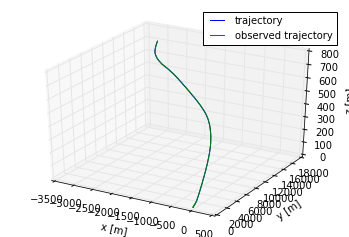

In [5]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mpl.rcParams['legend.fontsize'] = 10

ax = fig.gca(projection='3d')
ax.plot(x_state[0,:], x_state[3,:], x_state[6,:], label='trajectory')
ax.plot(y_meas[0,:], y_meas[3,:], y_meas[6,:], label='observed trajectory')
ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

plt.show()

In [6]:
## Kalman filter functions
def fnKF_predict( F , m, P, Q):
    # fnKF_predict implements the Kalman Filter predict step
    m_pred = np.dot(F,m);
    P_pred = np.dot(np.dot(F,P),np.transpose(F)) + Q;
    # m_pred and P_pred are the predicted mean state vector and covariance
    # matrix at the current time step before seeing the measurement.
    return m_pred, P_pred

def fnKF_update(m_minus, P_minus, y,H, R ):
    innovation_mean = np.dot(H,m_minus);
    prediction_covariance = (R + np.dot(np.dot(H,P_minus),np.transpose(H)));
    KalmanGain = np.dot(np.dot(P_minus,np.transpose(H)),np.linalg.inv(prediction_covariance));

    # Calculate estimated mean state vector and its covariance matrix.
    m = m_minus + np.dot(KalmanGain , (y - innovation_mean));
    P = P_minus - np.dot(np.dot(KalmanGain,prediction_covariance),np.transpose(KalmanGain));
    return m,P

In [7]:
# Initialize the matrix which stores the estimated covariance matrices at each time step.
P_cov = np.zeros((nVars,nVars,len(t))); # to store all the estimated covariance matrices
P_cov[:,:,0] = P0;
# trace of covariance matrix
trace_cov = np.zeros(len(t));
trace_cov[0] = np.trace(P0);

# state vector estimate stored in x_hat
x_hat = np.zeros((nVars,len(t)),dtype=float);
x_hat[:,0] = y_meas[:,0];

# Run Kalman filter on measured data
for index in range (1,len(t)):
    # Execute Kalman prediction step
    [m_pred,P_pred] = fnKF_predict( stm3 , x_hat[:,index-1], P_cov[:,:,index-1], Qd3);
    # Execute Kalman update step
    [m,P]=fnKF_update(m_pred, P_pred, y_meas[:,index-1],H3, R3 );
    # Store away filter estimates
    x_hat[:,index] =  m;
    P_cov[:,:,index] = P;
    # Check trace of covariance matrix
    trace_cov[index] = np.trace(P);

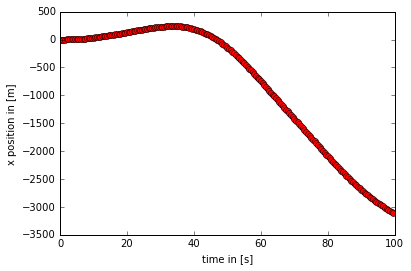

In [8]:
# Plot estimated x position vs true values
fig = plt.figure()
plt.plot(t,x_state[0,:],'b.')
plt.plot(t,x_hat[0,:],'ro')
plt.ylabel('x position in [m]')
plt.xlabel('time in [s]')
plt.show()

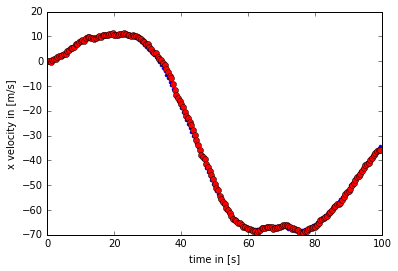

In [9]:
# Plot estimated x velocity vs true values
fig = plt.figure()
plt.plot(t,x_state[1,:],'b.')
plt.plot(t,x_hat[1,:],'ro')
plt.ylabel('x velocity in [m/s]')
plt.xlabel('time in [s]')
plt.show()

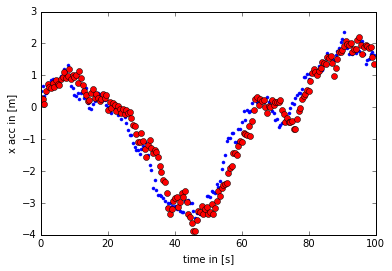

In [10]:
# Plot estimated x acceleration vs true values
fig = plt.figure()
plt.plot(t,x_state[2,:],'b.')
plt.plot(t,x_hat[2,:],'ro')
plt.ylabel('x acc in [m]')
plt.xlabel('time in [s]')
plt.show()

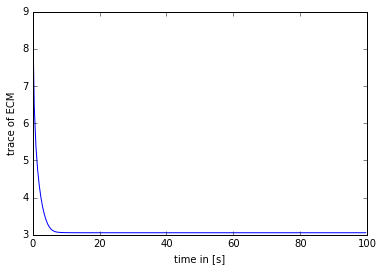

In [11]:
# Plot trace of covariance matrix.
fig = plt.figure()
plt.plot(t,trace_cov[:],'b')
plt.ylabel('trace of ECM')
plt.xlabel('time in [s]')
plt.show()